In [14]:
# -*- coding:utf-8 -*-
# handwritten digits recognition
# Data: MINIST
# size: 28*28  train-->6w test-->1w

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# 超参数
epoches = 4
n_classes = 10
batch_size = 100
lr = 0.001

In [16]:
train_curve = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# 得到 训练数据&测试数据 
# 调用torch中的torchvision得到MNIST数据集
train_dataset = torchvision.datasets.MNIST('/Users/jsheng/PycharmProjects/IJCAI18/assignment1/data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST('/Users/jsheng/PycharmProjects/IJCAI18/assignment1/data/', train=False, transform=transforms.ToTensor(), download=False)
train = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
test = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=5)

In [18]:
# cnn
class ClassifyCNN(nn.Module):
    def __init__(self, n_classes):
        super(ClassifyCNN, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2
            ),  # 16*28*28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )  # 16*14*14
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2
            ),  # 32*14*14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )  # 32*7*7
        )
        self.dropout = nn.Dropout2d()
        self.fc = nn.Linear(in_features=7*7*32, out_features=n_classes)

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.dropout(x)
        out = self.fc(x.view(x.size(0), -1))

        return out

classify = ClassifyCNN(n_classes).to(device)
print(classify) # 打印模型结构

ClassifyCNN(
  (cnn1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout2d(p=0.5)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [19]:
# 损失函数和优化方法
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵
optimizer = optim.Adam(params=classify.parameters(), lr=lr)

In [20]:
# train
total_step = len(train)
sum_loss = 0
for epoch in range(epoches):
    for i, (images, targets) in enumerate(train):
        images = images.to(device)
        targets = targets.to(device)
        preds = classify(images)

        loss = criterion(preds, targets)
        sum_loss += loss.item()
        loss.backward()
        criterion.zero_grad()
        optimizer.step()
        if (i+1)%100==0:
            print('[{}|{}] step:{}/{} loss:{:.2f}'.format(epoch+1, epoches, i+1, total_step, loss.item()))
    train_curve.append(sum_loss)
    sum_loss = 0

[1|4] step:100/600 loss:3.89
[1|4] step:200/600 loss:1.72
[1|4] step:300/600 loss:0.98
[1|4] step:400/600 loss:0.71
[1|4] step:500/600 loss:0.92
[1|4] step:600/600 loss:0.68
[2|4] step:100/600 loss:0.55
[2|4] step:200/600 loss:0.65
[2|4] step:300/600 loss:0.31
[2|4] step:400/600 loss:0.42
[2|4] step:500/600 loss:0.65
[2|4] step:600/600 loss:0.21
[3|4] step:100/600 loss:0.48
[3|4] step:200/600 loss:0.59
[3|4] step:300/600 loss:0.53
[3|4] step:400/600 loss:0.60
[3|4] step:500/600 loss:0.56
[3|4] step:600/600 loss:0.70
[4|4] step:100/600 loss:0.47
[4|4] step:200/600 loss:0.47
[4|4] step:300/600 loss:0.78
[4|4] step:400/600 loss:0.53
[4|4] step:500/600 loss:0.51
[4|4] step:600/600 loss:0.93


In [21]:
# 测试模式
classify.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = classify(images)
        _, maxIndexes = torch.max(outputs, 1)
        correct += (maxIndexes==labels).sum().item()
        total += labels.size(0)

    print('in 1w test_data correct rate = {:.4f}'.format((correct/total)*100))

in 1w test_data correct rate = 94.4300


In [22]:
torch.save(classify.state_dict(), '/Users/jsheng/PycharmProjects/IJCAI18/assignment1/model/cnn_classify.pt') # 模型保存

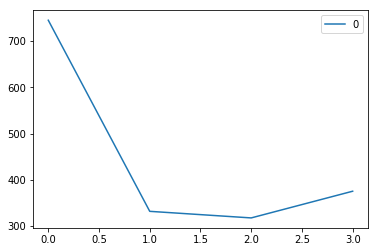

In [23]:
pd.DataFrame(train_curve).plot() # loss曲线

In [24]:
print('done!')

done!
